In [1]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib


mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

from run_id import run_id

run_id = 1771

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

docs = Doc.objects.filter(
    query=runstat.query,
    content__iregex="\w"
)



In [2]:
years = list(range(1990,2015))
years

s_solutions = []
ip_solutions = []

r = "(?:\W|^)solution|political action|policy"

for y in years:
    ydocs = docs.filter(PY=y)
    sdocs = ydocs.filter(content__iregex=r)
    s_count = sdocs.count()
    s_solutions.append(s_count/ydocs.count())
    ip_docs = ydocs.filter(ipccref__isnull=False)
    ip_solution_docs = ip_docs.filter(content__iregex=r)
    try:
        ip_solutions.append(ip_solution_docs.count()/ip_docs.count())
    except:
        ip_solutions.append(0)
    #ipdocs = ydocs.filter()
    

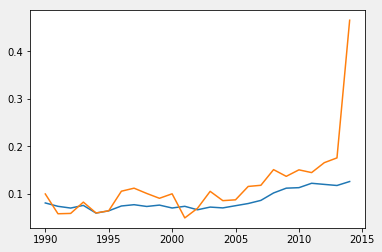

In [3]:
fig = plt.figure()

plt.plot(years,s_solutions)
plt.plot(years, ip_solutions)

fig.patch.set_facecolor('#f0f0f0')    
#plt.tight_layout()

plt.savefig(
    f'../plots/solutions.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
)
plt.show()

In [4]:
if runstat.method=="DT":
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
        topic__topicdtopic__dynamictopic__run_id=run_id,
        topic__topicdtopic__score__gt=runstat.dt_threshold
    ).values('topic__topicdtopic__dynamictopic__id')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')*F('topic__topicdtopic__score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__topicdtopic__dynamictopic__title',
        'solution',
        'topic__topicdtopic__dynamictopic__score'
    ))).rename(columns={
        'topic__topicdtopic__dynamictopic__title':'topic__title',
        'topic__topicdtopic__dynamictopic__score': 'score'
    })
else:
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
    ).values('topic__title')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__title',
        'solution',
        'score'
    )))
    
df.head()
                                     
                                    


,score,solution,topic__title
0,0.003203,0.0,"{adaptation, vulnerability, farmer}"
1,0.003203,0.0,"{adaptation, vulnerability, farmer}"
2,0.003204,0.0,"{adaptation, vulnerability, farmer}"
3,0.003205,0.0,"{adaptation, vulnerability, farmer}"
4,0.003205,0.0,"{adaptation, vulnerability, farmer}"


In [5]:
df.sort_values('solution',ascending=False).head()

,score,solution,topic__title
1482699,0.139472,0.139472,"{wetland, marsh, habitat}"
1482692,0.130641,0.130641,"{wetland, marsh, habitat}"
1482683,0.124168,0.124168,"{wetland, marsh, habitat}"
1482681,0.124085,0.124085,"{wetland, marsh, habitat}"
65573,0.123408,0.123408,"{biochar, application, amendment}"
